In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import json

from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import stats
from scipy.stats import gaussian_kde

from scipy.spatial import ConvexHull, convex_hull_plot_2d

from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

In [4]:
from scipy.spatial import Delaunay
import numpy as np

# https://stackoverflow.com/questions/50549128/boundary-enclosing-a-given-set-of-points

#  matlab boundary - https://stackoverflow.com/questions/31836709/what-algorithm-does-matlabs-boundary-function-use

# https://www.mathworks.com/help/matlab/ref/boundary.html

#  javascript implementation of hull - https://github.com/AndriiHeonia/hull

# alpha shape https://en.wikipedia.org/wiki/Alpha_shape
# https://doc.cgal.org/latest/Alpha_shapes_2/index.html

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [5]:
def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst

In [5]:
"""main function"""
folders = [f for f in listdir("data/input/")]
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        
        name = file.replace(".csv","")
        print(name)
        
        # # Constructing the input point data
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
        # print(inside)
        points = np.vstack([x[inside], y[inside]]).T
        # print(points)

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=0.4, only_outer=True)
        
#         getting ordered boundaries
        orderedBoundaries = stitch_boundaries(edges)
    
        maxL = []
        index = []
        for i in range(len(orderedBoundaries)):
#             print(len(orderedBoundaries[i]))
            if len(orderedBoundaries[i]) > 10:
                maxL.append(len(orderedBoundaries[i]))
                index.append(i)
    
        count = 0
        shapeData = []

        for i in index:
            bound = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    bound.append({'X': points[j[0]][0], 'Y': points[j[0]][1]})
                    bound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})
                    count = count + 1
                else:
                    bound.append({'X': points[j[1]][0], 'Y': points[j[1]][1]})

            shapeData.append(bound)
                

#         with open('data/output/{}/{}.json'.format(folder, name), 'w') as outfile:
#             json.dump(shapeData, outfile)
#         print("extracted {}".format(file))



0.1


<ipython-input-3-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


0.11


<ipython-input-3-5c4a71e317d3>:55: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - a) * (s - b) * (s - c))


0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
210
211
212
213
214
215
216
217
218
219


<ipython-input-4-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


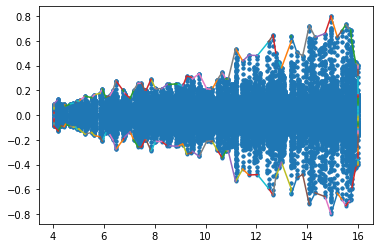

In [6]:
df = pd.read_csv('data/input/contrails1/0.2.csv')
# # Constructing the input point data
x = df['Points:0'].to_numpy()
y = df['Points:1'].to_numpy()

inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
# print(inside)
points = np.vstack([x[inside], y[inside]]).T
# print(points)

# Computing the alpha shape
edges = alpha_shape(points, alpha=0.25, only_outer=True)

# Plotting the output
plt.figure()
plt.plot(points[:, 0], points[:, 1], '.')
# plt.ylim([-1, 1])
for i, j in edges:
#     print(i, j, points[[i, j], 0], points[[i, j], 1])
    
    plt.plot(points[[i, j], 0], points[[i, j], 1])


plt.show()

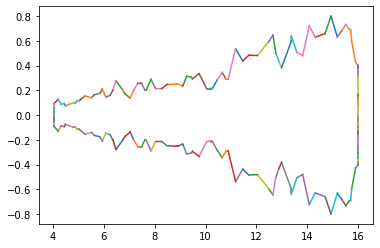

In [7]:
plt.figure()

for i, j in edges:
#     print(i, j, points[[i, j], 0], points[[i, j], 1])
    
    plt.plot(points[[i, j], 0], points[[i, j], 1])


plt.show()

In [8]:
orderedBoundaries = stitch_boundaries(edges)

In [9]:
maxL = []
index = []
for i in range(len(orderedBoundaries)):
#     print(len(orderedBoundaries[i]))
    if len(orderedBoundaries[i]) > 10:
        maxL.append(len(orderedBoundaries[i]))
        index.append(i)
        
print(index, maxL)

[0] [250]


In [15]:
X = []
Y = []
count = 0
# shapeData = []
# print(orderedBoundaries)


for i in index:
    bound = []
    count = 0
    for j in orderedBoundaries[i]:    
        if count == 0:
            bound.append((points[j[0]][0], points[j[0]][1]))
            bound.append((points[j[1]][0], points[j[1]][1]))
#             X.append(points[j[0]][0])
#             X.append(points[j[1]][0])
#             Y.append(points[j[0]][1])
#             Y.append(points[j[1]][1])
            count = count + 1
        else:
            bound.append((points[j[1]][0], points[j[1]][1]))
#             X.append(points[j[1]][0])
#             Y.append(points[j[1]][1])
#     shapeData.append(bound)
print(bound)

[(6.7409, -0.20243), (6.7732, -0.18917), (6.8482, -0.16975), (7.032, -0.1361), (7.1697, -0.20057), (7.3373, -0.25594), (7.478, -0.25754), (7.6110000000000015, -0.20159), (7.6601, -0.2007), (7.8535, -0.28902), (8.0203, -0.21798), (8.0532, -0.21316), (8.2716, -0.21356), (8.4894, -0.24823), (8.5492, -0.24718), (8.8536, -0.25201), (8.9223, -0.24897), (9.0946, -0.23462), (9.1187, -0.24221), (9.2544, -0.3138), (9.4379, -0.30633), (9.483, -0.29303), (9.7438, -0.3344), (10.042, -0.21331), (10.172, -0.20879), (10.212, -0.21566), (10.26, -0.21106), (10.458, -0.28493), (10.651, -0.34411), (10.795, -0.29336), (10.889, -0.29015), (11.179, -0.53614), (11.46, -0.4366100000000001), (11.702, -0.48382), (12.037, -0.48089), (12.474, -0.5916899999999999), (12.65, -0.6450899999999999), (12.76, -0.5021899999999999), (12.894, -0.42682), (12.986, -0.38224), (13.375, -0.5985277585292007), (13.375, -0.5985278772375522), (13.375, -0.6272634200686911), (13.375, -0.6272634803385005), (13.375, -0.63694), (13.587, -

In [16]:
polygon = Polygon(bound)

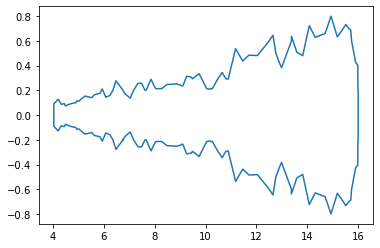

In [17]:
x,y = polygon.exterior.xy
plt.plot(x,y)

In [19]:
polygon.area

8.628672304000549

In [20]:
polygon.length

26.86166550333944

In [26]:
'''
https://stackoverflow.com/questions/19873596/convex-hull-area-in-python

https://towardsdatascience.com/the-concave-hull-c649795c0f0f
'''

'\nhttps://stackoverflow.com/questions/19873596/convex-hull-area-in-python\n\nhttps://towardsdatascience.com/the-concave-hull-c649795c0f0f\n'

210.csv


<ipython-input-4-5c4a71e317d3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a * b * c / (4.0 * area)


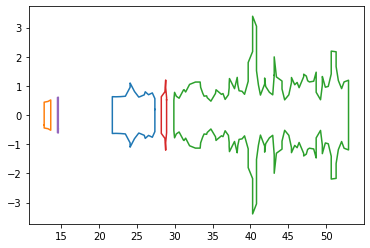

area = 59.07313967271047 , length = 102.02828951073394
211.csv


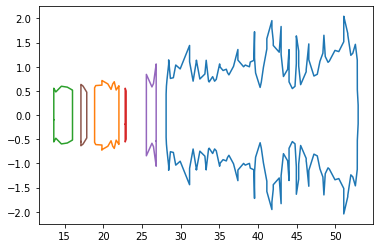

area = 62.44042575518492 , length = 104.39343629905926
212.csv


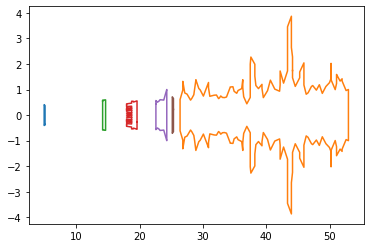

area = 64.66641142566559 , length = 120.34433589525555
213.csv


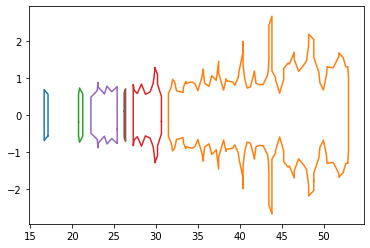

area = 58.321893849165185 , length = 97.6755823024765
214.csv


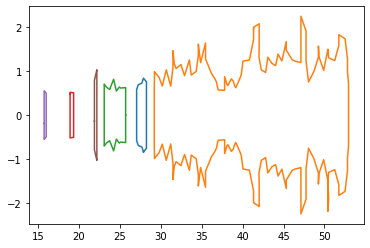

area = 61.66068096829855 , length = 95.06998361821617
215.csv


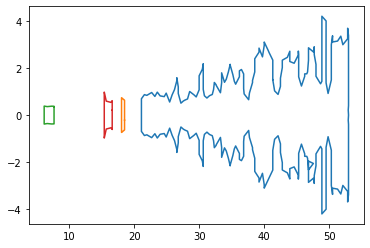

area = 108.99113892692257 , length = 136.99334652169534
216.csv


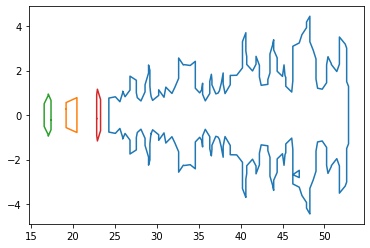

area = 105.22788114792678 , length = 136.4838538394273
217.csv


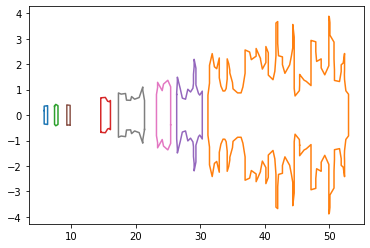

area = 102.09505367193329 , length = 150.16255179460876
218.csv


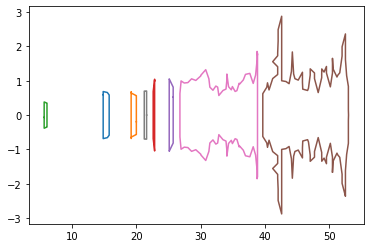

area = 59.235241709375124 , length = 107.57997756205887
219.csv


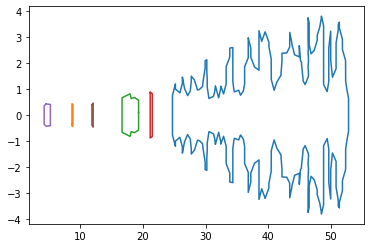

area = 105.76750247207718 , length = 138.1838022354173


In [36]:
# folders = [f for f in listdir("data/input/")]
folders = ['newData']
# print(folders)
for folder in folders:
    onlyfiles = [f for f in listdir("data/input/{}".format(folder)) ]
    for file in onlyfiles:
        df = pd.read_csv('data/input/{}/{}'.format(folder,file))
        print(file)
        x = df['Points:0'].to_numpy()
        y = df['Points:1'].to_numpy()

        inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
        # print(inside)
        points = np.vstack([x[inside], y[inside]]).T
        # print(points)

        # Computing the alpha shape
        edges = alpha_shape(points, alpha=0.4, only_outer=True)
        
        orderedBoundaries = stitch_boundaries(edges)
        
        maxL = []
        index = []
        for i in range(len(orderedBoundaries)):
        #     print(len(orderedBoundaries[i]))
            if len(orderedBoundaries[i]) > 10:
                maxL.append(len(orderedBoundaries[i]))
                index.append(i)

#         print(index, maxL)
        
        X = []
        Y = []
        count = 0
        shapeData = []
        # print(orderedBoundaries)


        for i in index:
            bound = []
            count = 0
            for j in orderedBoundaries[i]:    
                if count == 0:
                    bound.append((points[j[0]][0], points[j[0]][1]))
                    bound.append((points[j[1]][0], points[j[1]][1]))
                    count = count + 1
                else:
                    bound.append((points[j[1]][0], points[j[1]][1]))
            
            shapeData.append(Polygon(bound))

        polygon = MultiPolygon(shapeData)
        for geom in polygon.geoms:
            x,y = geom.exterior.xy
            plt.plot(x,y)
        plt.show()
        
        print("area = {} , length = {}".format(polygon.area , polygon.length))

In [30]:
a = [(0, 0), (0, 1), (1, 1), (1, 0), (0, 0)]
b = [(1, 1), (1, 2), (2, 2), (2, 1), (1, 1)]
mp = MultiPolygon([Polygon(a), Polygon(b)])
mp.area

2.0